In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install autogluon

In [3]:
!ls drive/MyDrive/pfa-case

# drive/MyDrive/pfa-case/san-francisco-ca_.geojson

'Kopi af Kopi af Kopi af model.ipynb'   sf_data.csv
'Kopi af Kopi af model.ipynb'	        sf_districts.csv
'Kopi af model.ipynb'		        sf_districts.gsheet
 model.ipynb			       'Unavngiven præsentation.gslides'
 san-francisco-ca_.geojson	        visualize.ipynb


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [7]:
data_path = 'drive/MyDrive/pfa-case/sf_data.csv'
districts_path = 'drive/MyDrive/pfa-case/sf_districts.csv'

In [101]:
# Use pandas to read the CSV file into a DataFrame
crime_data = pd.read_csv(data_path, sep=";")
crime_data

train_crime, test_crime = train_test_split(crime_data, test_size=0.2, random_state=42)

In [105]:
def transform_df(df):
    df['date'] = pd.to_datetime(df['date'])

    # Group by date and count the number of crimes
    daily_crime_count = df.groupby(df['date'].dt.date).size().reset_index(name='crime_count')

    # #add ID

    # daily_crime_count.index=["CC" for _ in range(len(daily_crime_count))]
    # daily_crime_count
    daily_crime_count = daily_crime_count.assign(item_id='CC')
    # Display the resulting dataframe
    daily_crime_count['date'] =  pd.to_datetime(daily_crime_count['date'])
    daily_crime_count = daily_crime_count[daily_crime_count['date'].dt.year != 2018]
    return daily_crime_count


daily_crime_count = transform_df(crime_data)

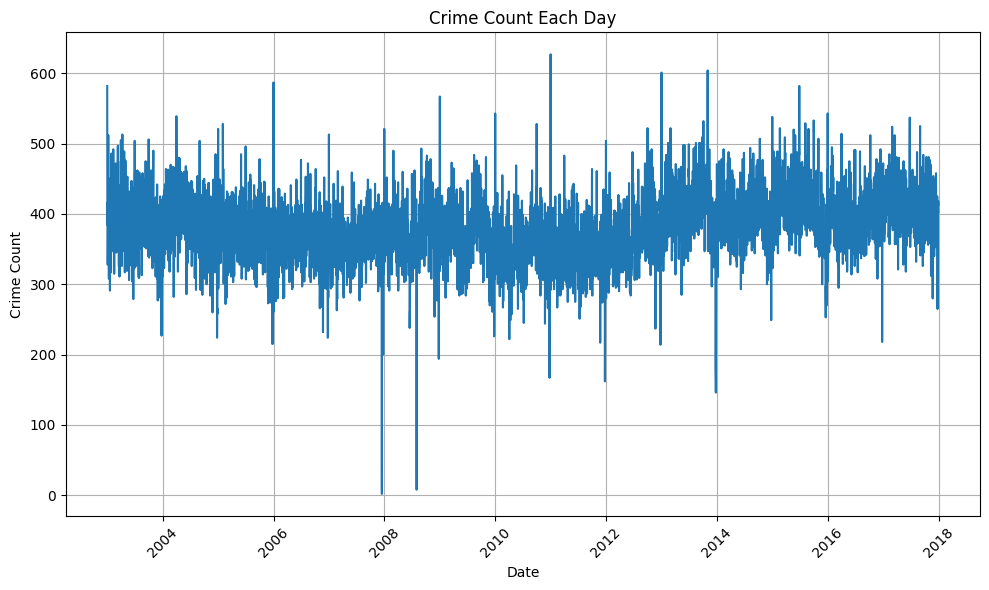

In [106]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_crime_count['date'], daily_crime_count['crime_count'])
plt.title('Crime Count Each Day')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
#removing 2018



In [124]:
# Filter out rows for the test set (2017)
test_set = daily_crime_count[daily_crime_count['date'].dt.year == 2017]

# Filter out rows for the training set (excluding 2017)
train_set = daily_crime_count[daily_crime_count['date'].dt.year != 2017]

# test_set = transform_df(test_crime)
# train_set = transform_df(train_crime)

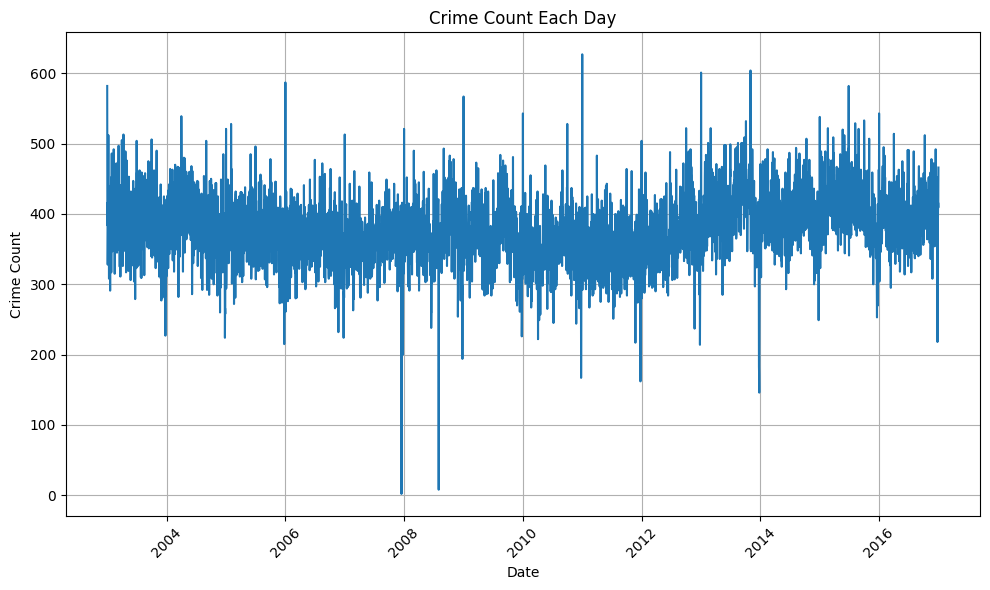

In [125]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_set['date'], train_set['crime_count'])
plt.title('Crime Count Each Day')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Training model


In [127]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [128]:
train_set

,date,crime_count,item_id
0,2003-01-01,582,CC
1,2003-01-02,384,CC
2,2003-01-03,416,CC
3,2003-01-04,328,CC
4,2003-01-05,367,CC
...,...,...,...
5108,2016-12-27,424,CC
5109,2016-12-28,394,CC
5110,2016-12-29,416,CC
5111,2016-12-30,409,CC


In [129]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train_set,
    id_column="item_id",
    timestamp_column="date"
)
train_data.head()

crime_count
item_id timestamp              
CC      2003-01-01          582
        2003-01-02          384
        2003-01-03          416
        2003-01-04          328
        2003-01-05          367

In [130]:
predictor = TimeSeriesPredictor(
    prediction_length=365,
    # path="autogluon-m4-hourly",
    target="crime_count",
    eval_metric="MASE",
    freq='D'
)
predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'AutogluonModels/ag-20240208_234044'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
GPU Count:          1
Memory Avail:       8.97 GB / 12.67 GB (70.8%)
Disk Space Avail:   44.35 GB / 78.19 GB (56.7%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 365,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'crime_count',
 'time_limit': 600,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'D'.
train_da

In [131]:
predictions = predictor.predict(train_data)
predictions.head()


data with frequency 'None' has been resampled to frequency 'D'.
data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
CC      2017-01-01  409.435699  361.754760  378.122647  389.925045   
        2017-01-02  395.483581  339.967175  359.024817  372.766718   
        2017-01-03  408.841322  347.282128  368.414135  383.651799   
        2017-01-04  402.263401  335.589664  358.477388  374.981048   
        2017-01-05  405.138266  333.943390  358.383129  376.005900   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
CC      2017-01-01  400.009759  409.435699  418.861639  428.946353   
        2017-01-02  384.508666  395.483581  406.458497  418.200445   
        2017-01-03  396.671821  408.841322  421.010823  434.030845   
        2017-01-04  389.082817  402.263401  415.443986  429.545754   
        2017-01-05  391.063908  405.138266  419.212624  434.270632   

                           0.8         0.9  
item_id timestamp                           
CC      2017-01-01  440.748752  457.116639  
        2017-01-02  431.942345  450.999987  
        2017-01-03  449.268508  470.400515  
        2017-01-04  446.049414  468.937139  
        2017-01-05  451.893403  476.333142

In [132]:
test_data = TimeSeriesDataFrame.from_data_frame(
    daily_crime_count,
    id_column="item_id",
    timestamp_column="date"
)
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency 'D'.
data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,AutoETS,-0.689453,-0.806894,2.948097,5.620609,6.736261,4
1,WeightedEnsemble,-0.693277,-0.767736,10.414062,12.875447,2.876484,9
2,DynamicOptimizedTheta,-0.708305,-0.854115,1.540167,1.640217,1.931554,5
3,AutoARIMA,-0.731752,-0.893948,1.240637,3.613618,1.907611,6
4,NPTS,-0.786305,-0.970639,7.465083,13.148935,7.802020,3
5,RecursiveTabular,-0.904939,-0.839738,7.463253,7.254838,35.416041,7
6,CrostonSBA,-0.914168,-1.136405,0.063537,0.042825,0.087399,2
7,DirectTabular,-1.028348,-1.066690,0.150457,0.121402,2.926117,8
8,SeasonalNaive,-1.387876,-1.428260,0.050601,0.044971,0.072766,1


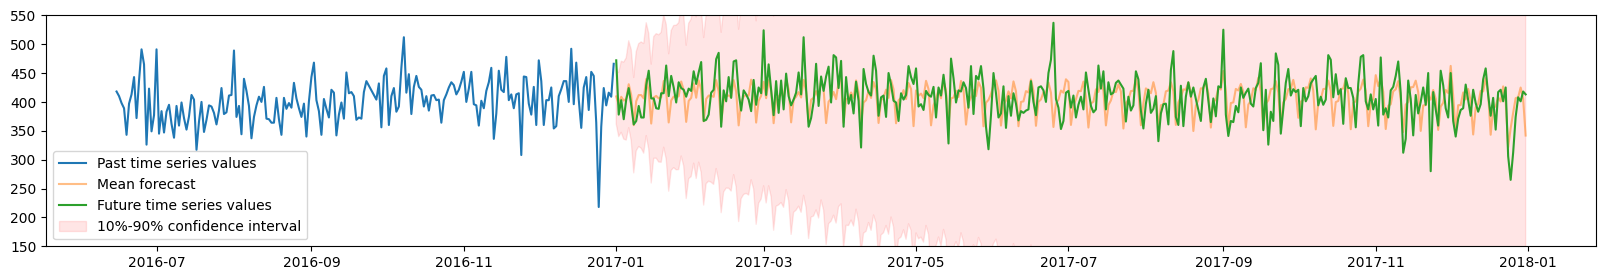

In [135]:

plt.figure(figsize=(20, 3))

item_id = 'CC'
y_past = train_data.loc[item_id]["crime_count"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["crime_count"][-365:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast", alpha=0.5)
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)

plt.ylim(150, 550)
plt.legend(loc='lower left')